In [22]:
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
import os
import sys
import warnings
sys.path.append(os.path.abspath("../lib"))
from merge import prepare_train_show
from prepare_data import make_cut, to_categorical

from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings("ignore", category=ConvergenceWarning) 

In [23]:
os.environ['PYSPARK_DRIVER_PYTHON_OPTS'] = "notebook"
os.environ['PYSPARK_DRIVER_PYTHON'] = sys.executable
os.environ['PYSPARK_PYTHON'] = sys.executable

spark = SparkSession \
    .builder \
    .appName("renovation") \
    .getOrCreate()

# set this parameter for date issue before 1582 (dpe database)
spark.conf.set("spark.sql.legacy.timeParserPolicy", "LEGACY")

In [24]:
# import files
# File location and type
file_location_array = [
    {"location": "../training/pred_tremi.csv",
        "name": "pred_tremi_full", "delimiter": ","},
    {"location": "../training/dico.csv", "name": "dictionary", "delimiter": "\t"}
]
file_type = "csv"

# CSV options
infer_schema = "true"
first_row_is_header = "true"
dataframes = {}

# The applied options are for CSV files. For other file types, these will be ignored.
for file in file_location_array:
    delimiter = file["delimiter"]
    file_location = file["location"]
    name = file["name"]
    dataframes[file["name"]] = (
        spark.read.format(file_type)
        .option("inferSchema", infer_schema)
        .option("header", first_row_is_header)
        .option("sep", delimiter)
        .load(file_location)
    )

In [25]:
# name the important datasets and cast to type
training_tremi = (
    dataframes['pred_tremi_full'].withColumns({
        'surface': F.col('surface').cast('int'),
        'heating_production': F.col('heating_production').cast('int'),
    })
)

dictionary = dataframes['dictionary']

In [26]:
# split training and prediction datasets
training_surf = training_tremi.filter(F.col('surface').isNotNull()).drop(
    'heating_production')
predicting_surf = training_tremi.filter(F.col('surface').isNull()).drop(
    'heating_production')

training_prod = training_tremi.filter(
    F.col('heating_production').isNotNull()).drop('surface')
predicting_prod = training_tremi.filter(
    F.col('heating_production').isNull()).drop('surface')

print(f"""
{training_surf.count() =}
{predicting_surf.count() =}\n
{training_prod.count() =}
{predicting_prod.count() =}\n
""")


training_surf.count() =12565
predicting_surf.count() =26933

training_prod.count() =11128
predicting_prod.count() =28370




In [27]:
from imblearn.over_sampling import SMOTE

# librairies
import numpy as np
import matplotlib.pyplot as plt

# usefull
from copy import deepcopy

# prepare data
from sklearn.model_selection import train_test_split
from prepare_data import prepare_dataset
from sklearn.model_selection import ShuffleSplit
from sklearn.preprocessing import StandardScaler

# scoring and training
from sklearn.metrics import f1_score
from train import train_hyper, choose_params, nb_possibility, iterate_params
from sklearn.model_selection import cross_val_score

# random forest
from sklearn.ensemble import RandomForestClassifier

# XGboost
from xgboost.sklearn import XGBClassifier

#hyperparams
from scipy.stats import uniform, randint

# insights
from show import show_matrix

In [28]:
RF_param = {'class_weight': 'balanced', 'max_depth': 19, 'n_estimators': 171}
balanced_params = {'class_weight': 'balanced', 'max_depth': 23, 'n_estimators': 174}

In [29]:
col_X_hot = [['occupation', 'nb_persons_home',
              'income', 'department_number'], []]
col_y = ['heating_production']
col_X_not_hot = [[col[0] for col in training_prod.dtypes if col[0] not in col_X_hot[i] + col_y] for i in range(len(col_X_hot))]

X, y, _ = prepare_dataset(training_prod, dictionary, col_X_hot[1], col_X_not_hot[1], col_y, False, True)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
X_test, X_valid, y_test, y_valid = train_test_split(X_test, y_test, test_size=0.5, random_state=42)

RF = RandomForestClassifier(**RF_param).fit(X_train, y_train)
y_pred = RF.predict(X_valid)

split = ShuffleSplit(4, test_size=0.4, random_state=42)

param_sample = {
    'random_state' : [42],
    'sampling_strategy' : [
        {5: 3120, 0: 3120, 1: 3000, 2: 2700, 4: 2500, 3: 2000},
        {5: 3916, 0: 3407, 1: 3000, 2: 2700, 4: 2500, 3: 2000},
        {5: 3120, 0: 3120, 1: 3120, 2: 3120, 4: 3120, 3: 3120},
        {5: 3120, 0: 3120, 1: 2500, 2: 2000, 4: 1800, 3: 1000},
    ],
    'k_neighbors' : [1,2,3]
}

current = [0 for _ in range(len(param_sample))]
max_hyper = [len(cut_param) - 1 for cut_param in param_sample.values()]
current_params = choose_params(current, param_sample)
all_poss = nb_possibility(max_hyper)
print(all_poss)

sm = SMOTE(**current_params)
X_res, y_res = sm.fit_resample(X_train, y_train)
# register score
RF_res = RandomForestClassifier(**balanced_params).fit(X_res, y_res)
y_pred_res = RF_res.predict(X_test)
score = f1_score(y_test, y_pred_res, average="micro")
max_score = deepcopy(score)
best_params = deepcopy(current_params)
best_model = deepcopy(RF_res)
scores = {}

scores[tuple([str(param) for param in current_params.values()])
       ] = deepcopy(score)

i = 0
nb_print = (all_poss//4) + 1
while not all(np.equal(current, max_hyper)):
    # choose params
    current = iterate_params(current, max_hyper)
    current_params = choose_params(current, param_sample)
    if i % nb_print == 0:
        print(i, current)
    i += 1
    sm = SMOTE(**current_params)
    X_res, y_res = sm.fit_resample(X_train, y_train)
    # register score
    RF_res = RandomForestClassifier(**balanced_params).fit(X_res, y_res)
    y_pred_res = RF_res.predict(X_test)
    score = f1_score(y_test, y_pred_res, average="micro")
    scores[tuple([str(param) for param in current_params.values()])
       ] = deepcopy(score)
    if score > max_score:
        max_score = deepcopy(score)
        best_params = deepcopy(current_params)
        best_model = deepcopy(RF_res)

12
0 [0, 1, 0]
4 [0, 1, 1]
8 [0, 1, 2]


In [30]:
sm = SMOTE(**best_params)
X_res, y_res = sm.fit_resample(X_train, y_train)

In [31]:
hyperparams = {
        'max_depth' : randint(1,50),
        'n_estimators': randint(50,200),
        # 'subsample' : [0.2, 0.5, 0.8, 1],
        # 'criterion' : ['friedman_mse', 'squared_error'],
        'class_weight': ['balanced'],
        # 'max_features' : {'auto', 'sqrt', 'log2'}
        # 'min_samples_split' : [2,5,10],
        # 'min_samples_leaf' : [1,2,3],
}
model = RandomForestClassifier

(best_model_res, best_score, best_params, scores) = train_hyper(hyperparams, model, X_res, y_res, split, 42, [], 0, 'f1_micro')
print(best_score, best_params)
y_pred_res = best_model_res.predict(X_valid)

0.6757716049382716 {'class_weight': 'balanced', 'max_depth': 48, 'n_estimators': 193}


In [32]:
y_proba = RF.predict_proba(X_valid)
y_proba_res = best_model_res.predict_proba(X_valid)

y_stack = []
for proba, proba_res, pred, pred_res in zip(y_proba, y_proba_res, y_pred, y_pred_res):
    if pred == pred_res or max(proba) > max(proba_res):
        y_stack.append(pred)
    else:
        y_stack.append(pred_res)
y_stack = np.array(y_stack).ravel()

In [33]:

training_prod_subclass = training_prod.filter(F.col('heating_production').isin([2,3,4,5])).withColumn('heating_production', F.col('heating_production') - 2)
training_prod_overclass = training_prod.filter(F.col('heating_production').isin([1,6])).withColumn('heating_production', F.when(F.col('heating_production') == 1, 0).otherwise(1))

training_prod_subclass.groupBy('heating_production').count().show()
training_prod_overclass.groupBy('heating_production').count().show()

+------------------+-----+
|heating_production|count|
+------------------+-----+
|                 1| 1075|
|                 3|  962|
|                 2|  561|
|                 0| 1207|
+------------------+-----+

+------------------+-----+
|heating_production|count|
+------------------+-----+
|                 1| 3916|
|                 0| 3407|
+------------------+-----+



0.4395833333333334 {'class_weight': 'balanced', 'max_depth': 44, 'n_estimators': 104}
0.6224537037037037 {'class_weight': 'balanced', 'max_depth': 32, 'n_estimators': 181}


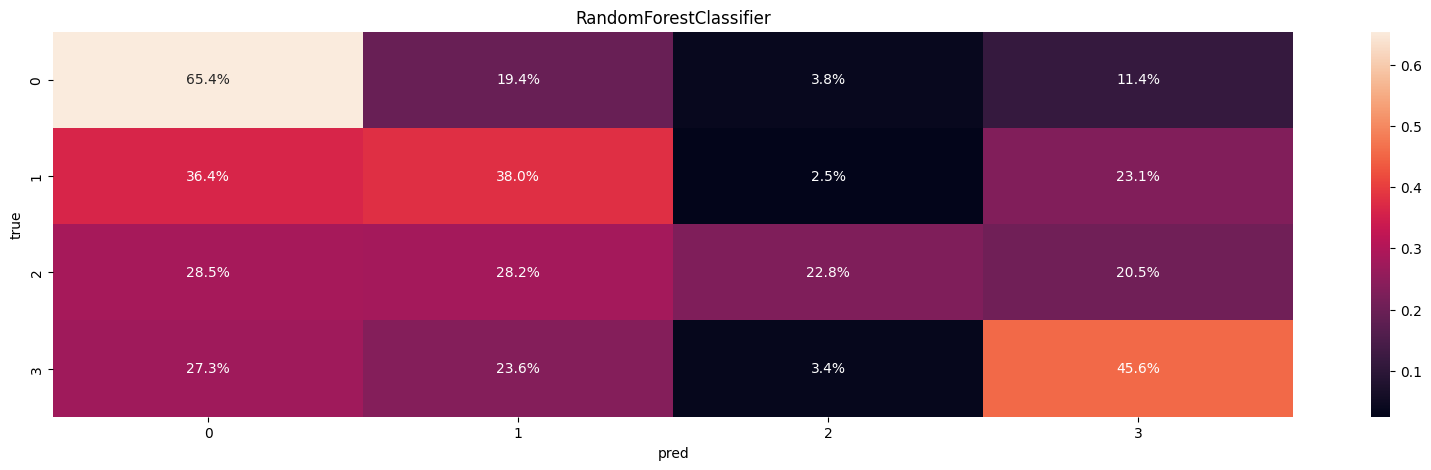

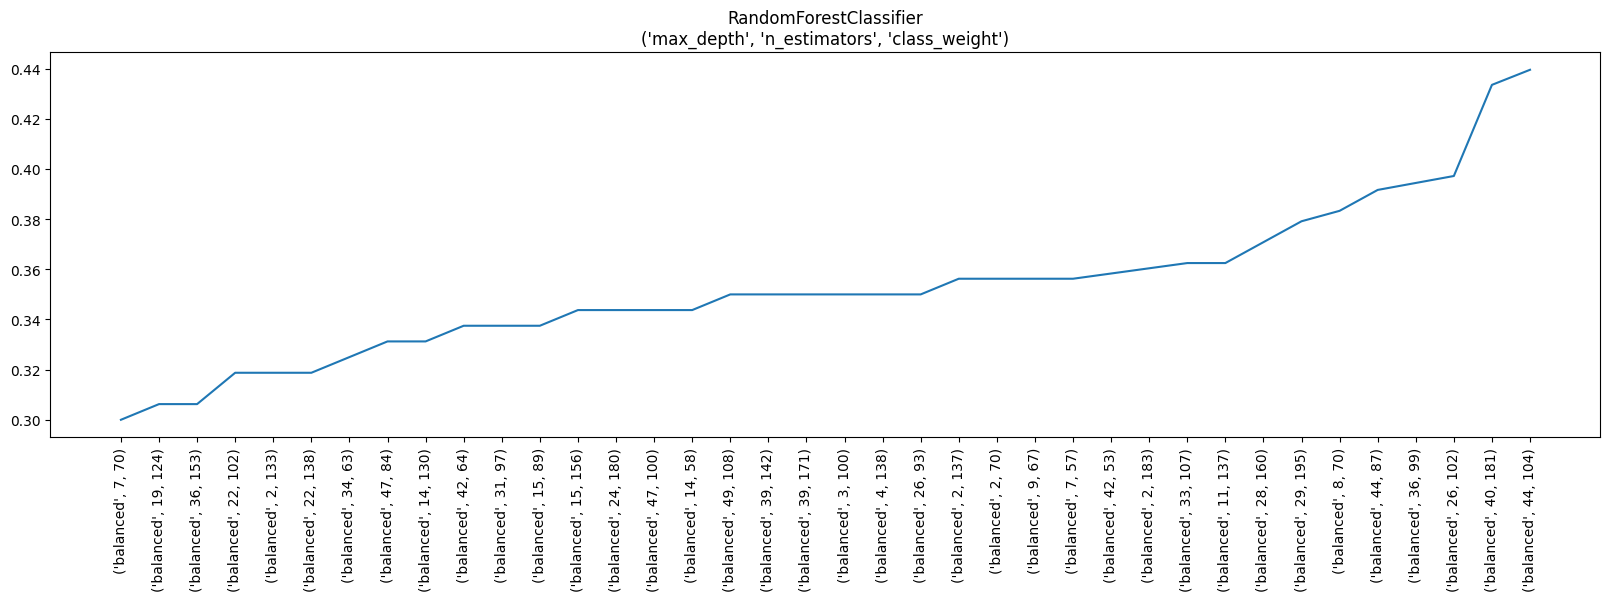

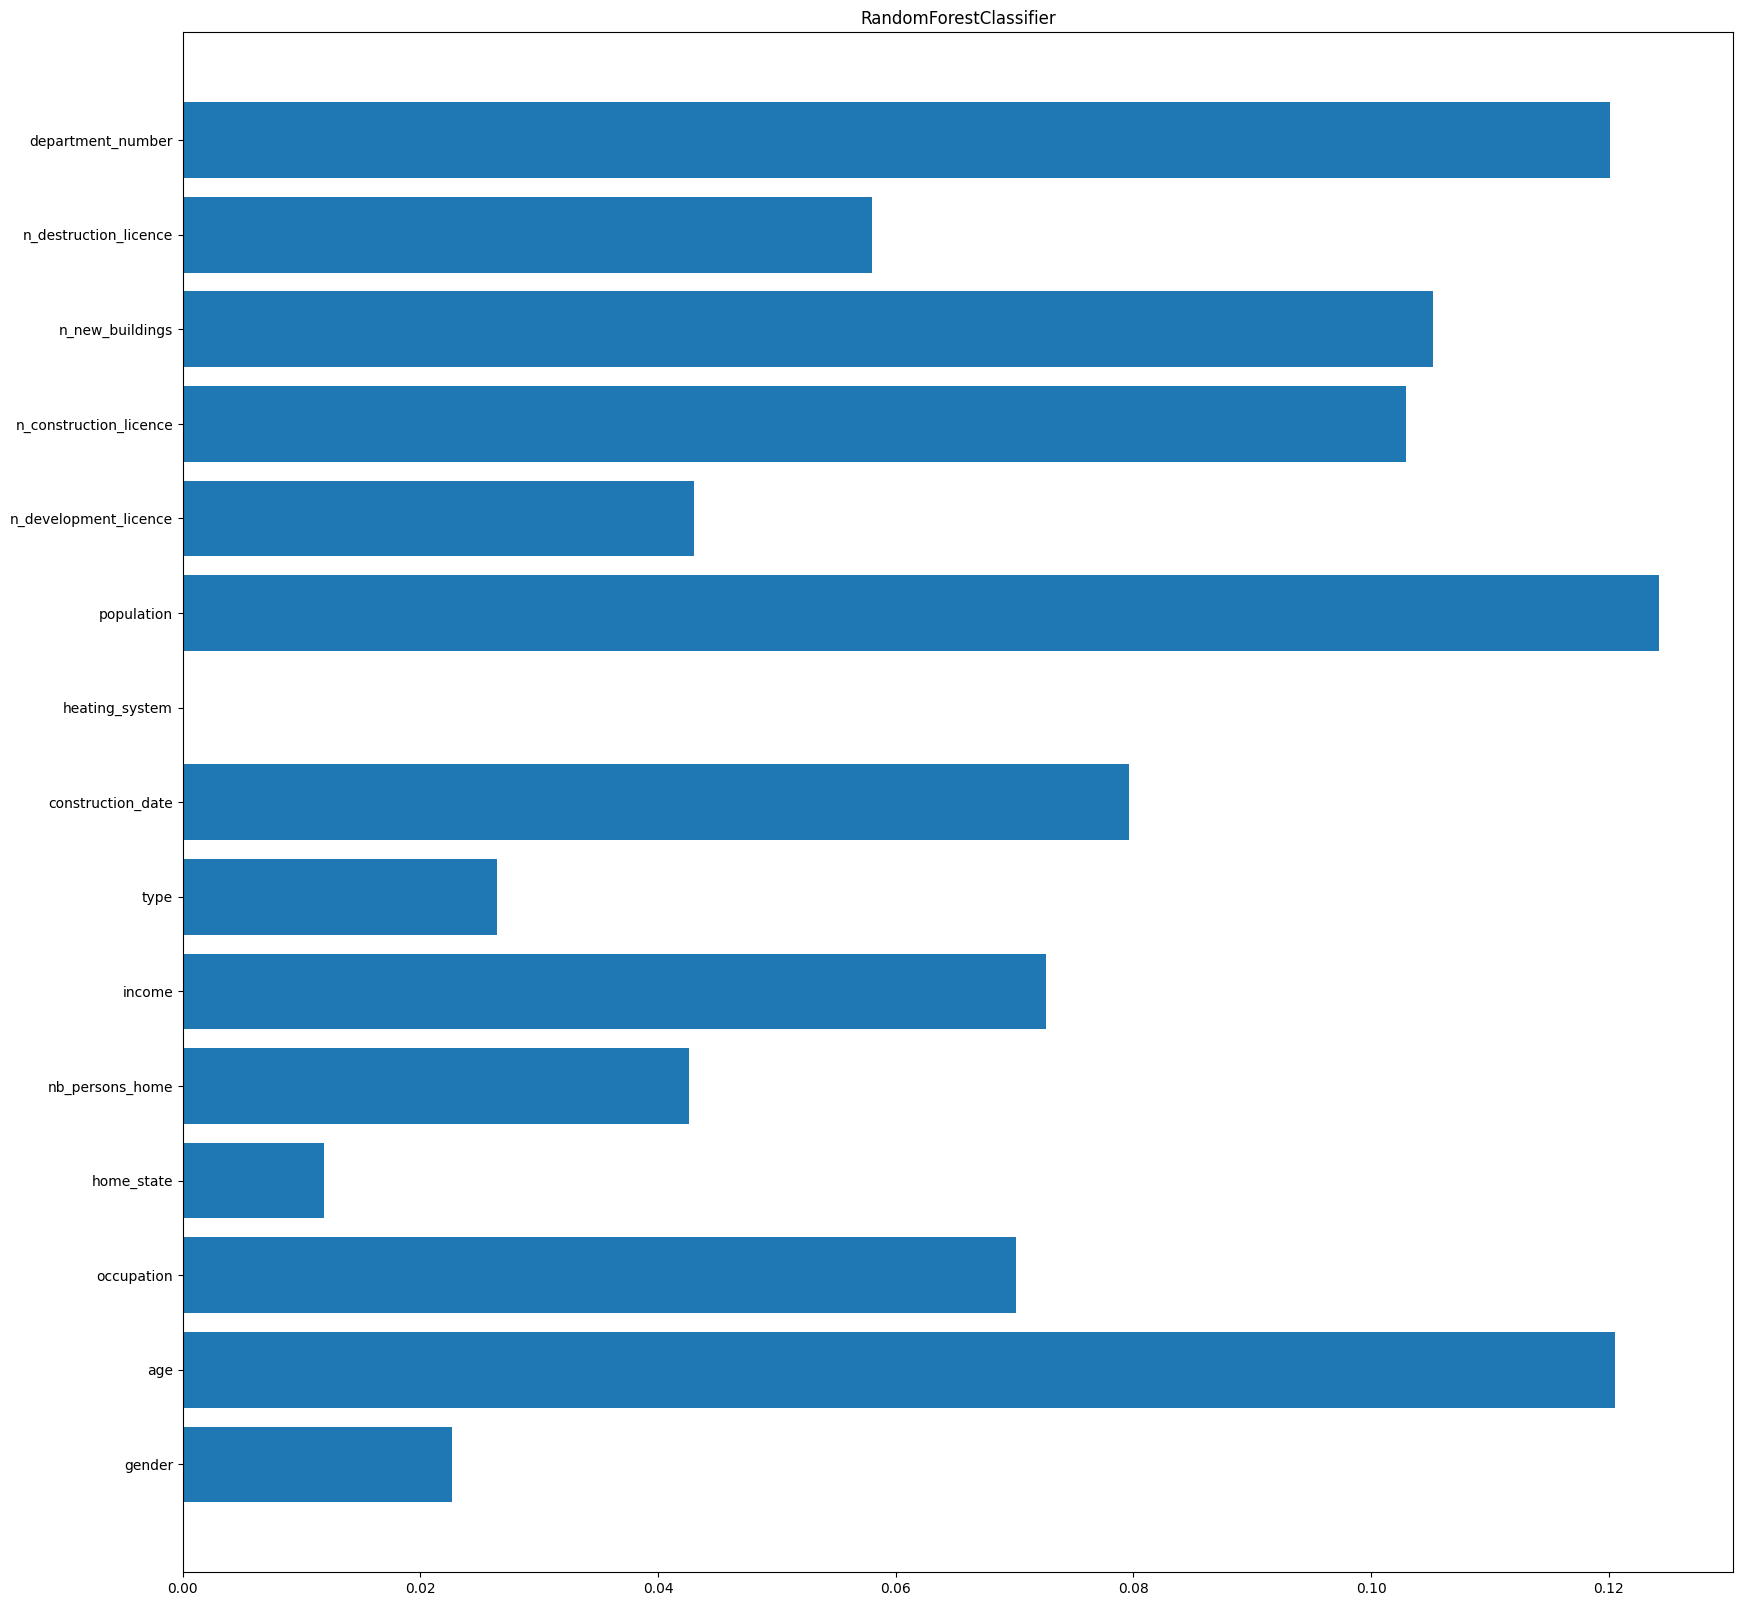

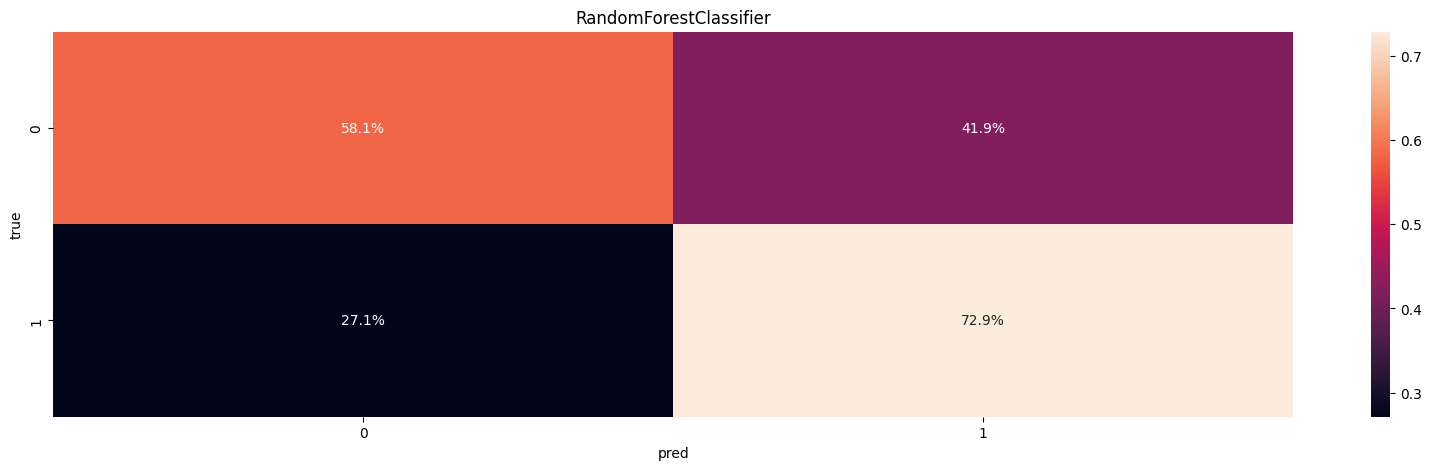

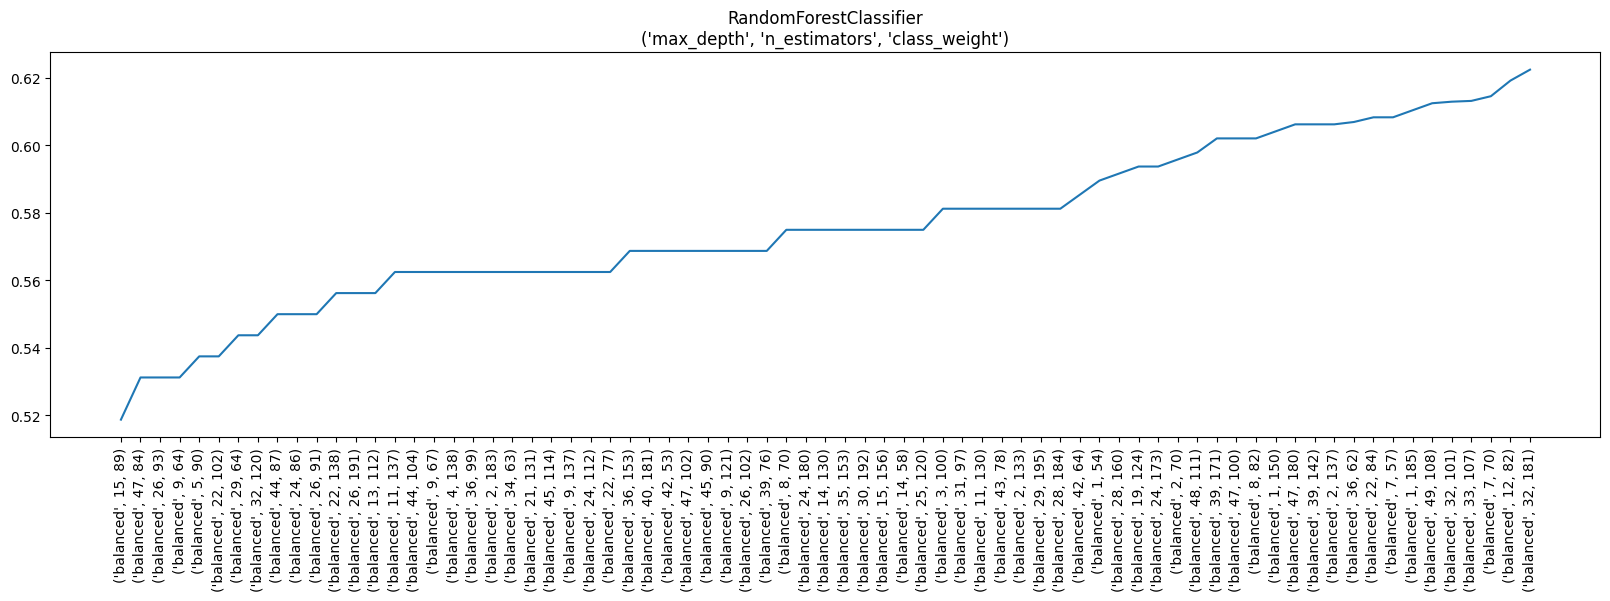

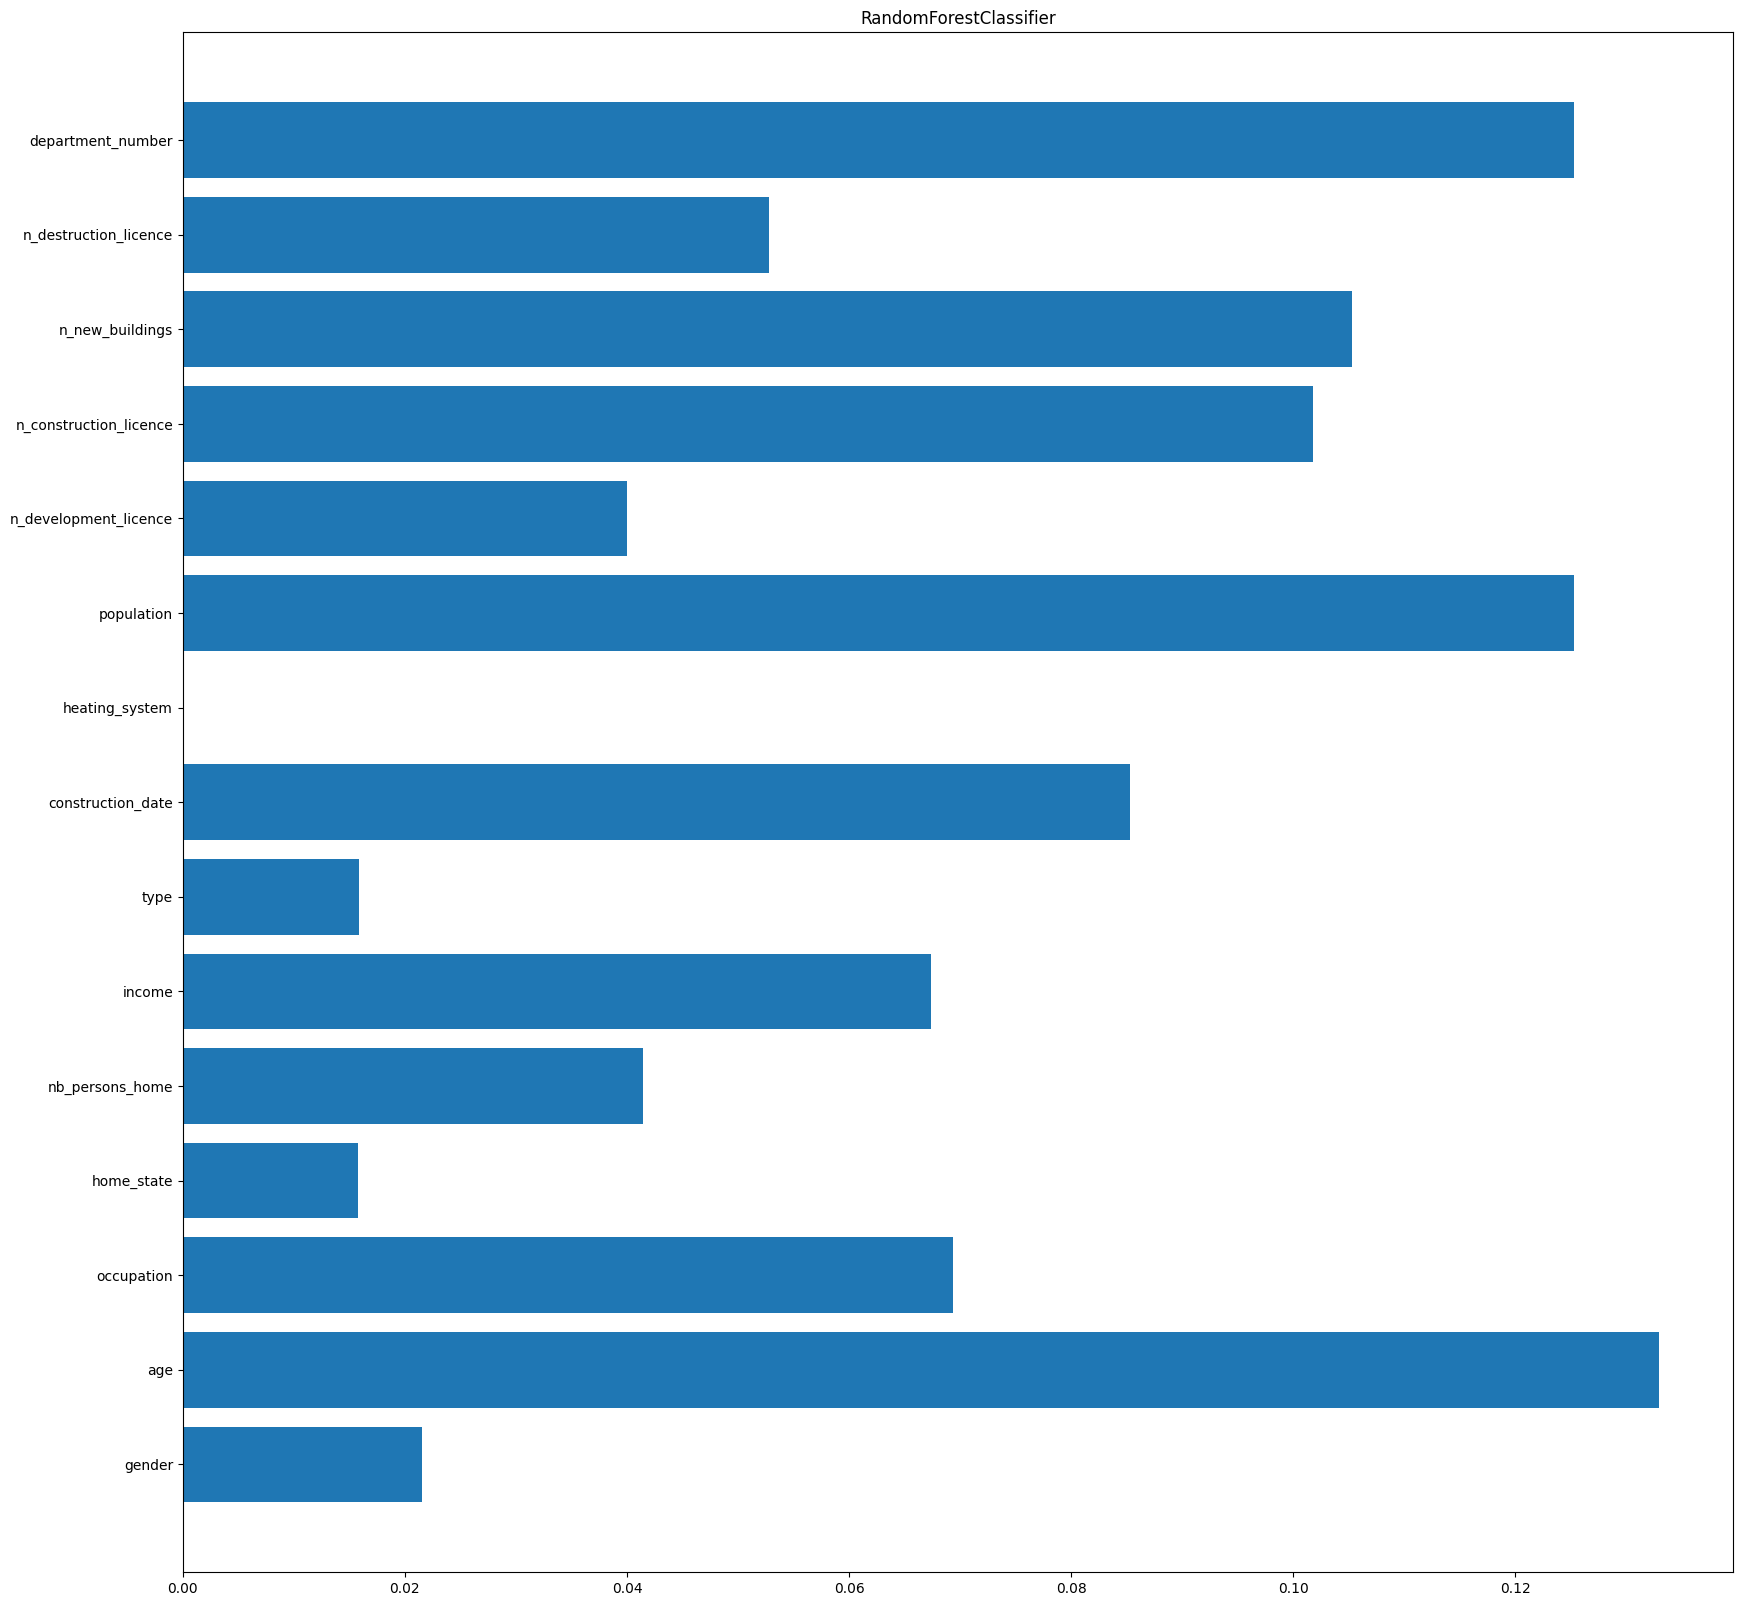

In [34]:
col_X_hot = [[]]
col_y = ['heating_production']
col_X_not_hot = [[col[0] for col in training_prod.dtypes if col[0] not in col_X_hot[i] + col_y] for i in range(len(col_X_hot))]
hyperparams_models = [
    {
        'max_depth' : randint(1,50),
        'n_estimators': randint(50,200),
        # 'subsample' : [0.2, 0.5, 0.8, 1],
        # 'criterion' : ['friedman_mse', 'squared_error'],
        'class_weight': ['balanced'],
        # 'max_features' : {'auto', 'sqrt', 'log2'}
        # 'min_samples_split' : [2,5,10],
        # 'min_samples_leaf' : [1,2,3],
    }
]
models = {
    'RandomForestClassifier' : RandomForestClassifier,
}

best_models_sub = prepare_train_show(training_prod_subclass, dictionary, [], col_X_hot, col_X_not_hot, col_y,
                         False, True, hyperparams_models, models, random_state=42, test_size=0.4, scoring='f1_micro')


best_models_over = prepare_train_show(training_prod_overclass, dictionary, [], col_X_hot, col_X_not_hot, col_y,
                         False, True, hyperparams_models, models, random_state=42, test_size=0.4, scoring='f1_micro')


In [35]:
y_proba_over = best_models_over['RandomForestClassifier'][0].predict_proba(X_valid)
y_proba_sub = best_models_sub['RandomForestClassifier'][0].predict_proba(X_valid)
y_pred_over = best_models_over['RandomForestClassifier'][0].predict(X_valid)
y_pred_sub = best_models_sub['RandomForestClassifier'][0].predict(X_valid)

y_stack2 = []
for proba_over, proba_sub, pred_over, pred_sub in zip(y_proba_over, y_proba_sub, y_pred_over, y_pred_sub):
    if max(proba_over)/1.7 > max(proba_sub):
        y_stack2.append(pred_over * 5)
    else:
        y_stack2.append(pred_sub + 1)


In [36]:

X_stack_over = best_models_over['RandomForestClassifier'][0].predict_proba(X_train)
X_stack_sub = best_models_sub['RandomForestClassifier'][0].predict_proba(X_train)
X_stack = StandardScaler().fit_transform(np.column_stack((X_stack_over[:,0], X_stack_sub, X_stack_over[:,1])))

print(X_stack.shape)

hyperparams_models = [
    {
        'max_depth' : randint(1,50),
        'n_estimators': randint(50,200),
        # 'subsample' : [0.2, 0.5, 0.8, 1],
        # 'criterion' : ['friedman_mse', 'squared_error'],
        'class_weight': ['balanced'],
        # 'max_features' : {'auto', 'sqrt', 'log2'}
        # 'min_samples_split' : [2,5,10],
        # 'min_samples_leaf' : [1,2,3],
    },
    {
        'learning_rate': uniform(0.03,0.3),
        'n_estimators' : randint(50,300),
        # 'subsample' : [0.2, 0.5, 0.8, 1],
        # 'criterion' : ['friedman_mse', 'squared_error'],
        # 'max_features' : {'auto', 'sqrt', 'log2'}
        # 'min_samples_split' : [2,5,10],
        # 'min_samples_leaf' : [1,2,3],
    }
]
models = {
    'RandomForestClassifier' : RandomForestClassifier,
    'XGBClassifier' : XGBClassifier,
}

best_models = {}
for hyperparams, (model_name, model) in zip(hyperparams_models, models.items()):
    (best_model_stack, best_score, best_params, scores) = train_hyper(hyperparams, model, X_stack, y_train, split, 42, [], 0, 'f1_micro')
    print(best_model_stack, best_score)
    best_models[model_name] = {'model' : best_model_stack, 'params': best_params, 'score': best_score}



(7789, 6)
RandomForestClassifier(class_weight='balanced', max_depth=24, n_estimators=112) 0.8916666666666667
XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.06164827794908118,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=77, n_jobs=None, num_parallel_tree=None,
              objective='multi:softprob', predictor=None, ...) 0.8863425925925926


In [37]:
X_stack_over = best_models_over['RandomForestClassifier'][0].predict_proba(X_valid)
X_stack_sub = best_models_sub['RandomForestClassifier'][0].predict_proba(X_valid)
X_test_stack = StandardScaler().fit_transform(np.column_stack((X_stack_over[:,0], X_stack_sub, X_stack_over[:,1])))

stacked_model = max(best_models.values(), key=lambda x: x['score'])['model']
y_stack_model = stacked_model.predict(X_test_stack)

In [38]:
from sklearn.ensemble import StackingClassifier
estimators = [
    ('rf1', best_models_sub['RandomForestClassifier'][0]),
    ('rf2', best_models_over['RandomForestClassifier'][0])
]

hyperparams_models = [
    {
        'max_depth' : [10, 15, 20, 25, 30],
        'n_estimators': [100, 133, 166, 200],
        # 'subsample' : [0.2, 0.5, 0.8, 1],
        # 'criterion' : ['friedman_mse', 'squared_error'],
        'class_weight': ['balanced'],
        # 'max_features' : {'auto', 'sqrt', 'log2'}
        # 'min_samples_split' : [2,5,10],
        # 'min_samples_leaf' : [1,2,3],
    },
    {
        'learning_rate': [0.03, 0.07, 0.1, 0.2, 0.3],
        'n_estimators' : [50, 70, 90, 110, 130],
        # 'subsample' : [0.2, 0.5, 0.8, 1],
        # 'criterion' : ['friedman_mse', 'squared_error'],
        # 'max_features' : {'auto', 'sqrt', 'log2'}
        # 'min_samples_split' : [2,5,10],
        # 'min_samples_leaf' : [1,2,3],
    }
]
models = {
    'RandomForestClassifier' : RandomForestClassifier,
    'XGBClassifier' : XGBClassifier,
}

best = {}
for hyperparams, (model_name, model) in zip(hyperparams_models, models.items()):
    current = [0 for _ in range(len(hyperparams))]
    max_hyper = [len(cut_param) - 1 for cut_param in hyperparams.values()]
    current_params = choose_params(current, hyperparams)
    all_poss = nb_possibility(max_hyper)
    print(all_poss)

    parametrized_model = model(**current_params)
    stack = StackingClassifier(estimators, parametrized_model, cv="prefit")
    # register score
    stack.fit(X_train, y_train)
    score = f1_score(y_test, stack.predict(X_test), average = 'micro')
    max_score = deepcopy(score)
    best_params = deepcopy(current_params)
    best_model = deepcopy(stack)


    i = 0
    nb_print = (all_poss//4) + 1
    while not all(np.equal(current, max_hyper)):
        # choose params
        current = iterate_params(current, max_hyper)
        current_params = choose_params(current, hyperparams)
        if i % nb_print == 0:
            print(i, current)
        i += 1
        parametrized_model = model(**current_params)
        stack = StackingClassifier(estimators, parametrized_model, cv="prefit")
        # register score
        stack.fit(X_train, y_train)
        score = f1_score(y_test, stack.predict(X_test), average = 'micro')

        if score > max_score:
            max_score = deepcopy(score)
            best_params = deepcopy(current_params)
            best_model = deepcopy(stack)
    print(max_score, best_params)
    best[model_name] = {'model' : best_model, 'params': best_params, 'score': score}



20
0 [1, 0, 0]
6 [2, 1, 0]
12 [3, 2, 0]
18 [4, 3, 0]
0.9167165967645297 {'max_depth': 15, 'n_estimators': 200, 'class_weight': 'balanced'}
25
0 [1, 0]
7 [3, 1]
14 [0, 3]
21 [2, 4]
0.9191132414619533 {'learning_rate': 0.1, 'n_estimators': 50}


In [39]:
best_stacked_model = max(best.values(), key=lambda x: x['score'])['model']
y_pred_stack = best_stacked_model.predict(X_valid)

RF : {'model': RandomForestClassifier(class_weight='balanced', max_depth=19, n_estimators=171), 'score': 0.4532934131736527}
RF_sampled : {'model': RandomForestClassifier(class_weight='balanced', max_depth=48, n_estimators=193), 'score': 0.437125748502994, 'sm': SMOTE(k_neighbors=1, random_state=42,
      sampling_strategy={0: 3120, 1: 3120, 2: 3120, 3: 3120, 4: 3120, 5: 3120})}
stack RF/RF_res : {'model': [RandomForestClassifier(class_weight='balanced', max_depth=19, n_estimators=171), RandomForestClassifier(class_weight='balanced', max_depth=48, n_estimators=193)], 'score': 0.4431137724550898}
satck RFover/RFsub div : {'model': [RandomForestClassifier(class_weight='balanced', max_depth=44, n_estimators=104), RandomForestClassifier(class_weight='balanced', max_depth=32, n_estimators=181)], 'score': 0.7371257485029941, 'div': 1.7}
satck RFover/RFsub hand : {'model': RandomForestClassifier(class_weight='balanced', max_depth=24, n_estimators=112), 'estimators': [RandomForestClassifier(cl

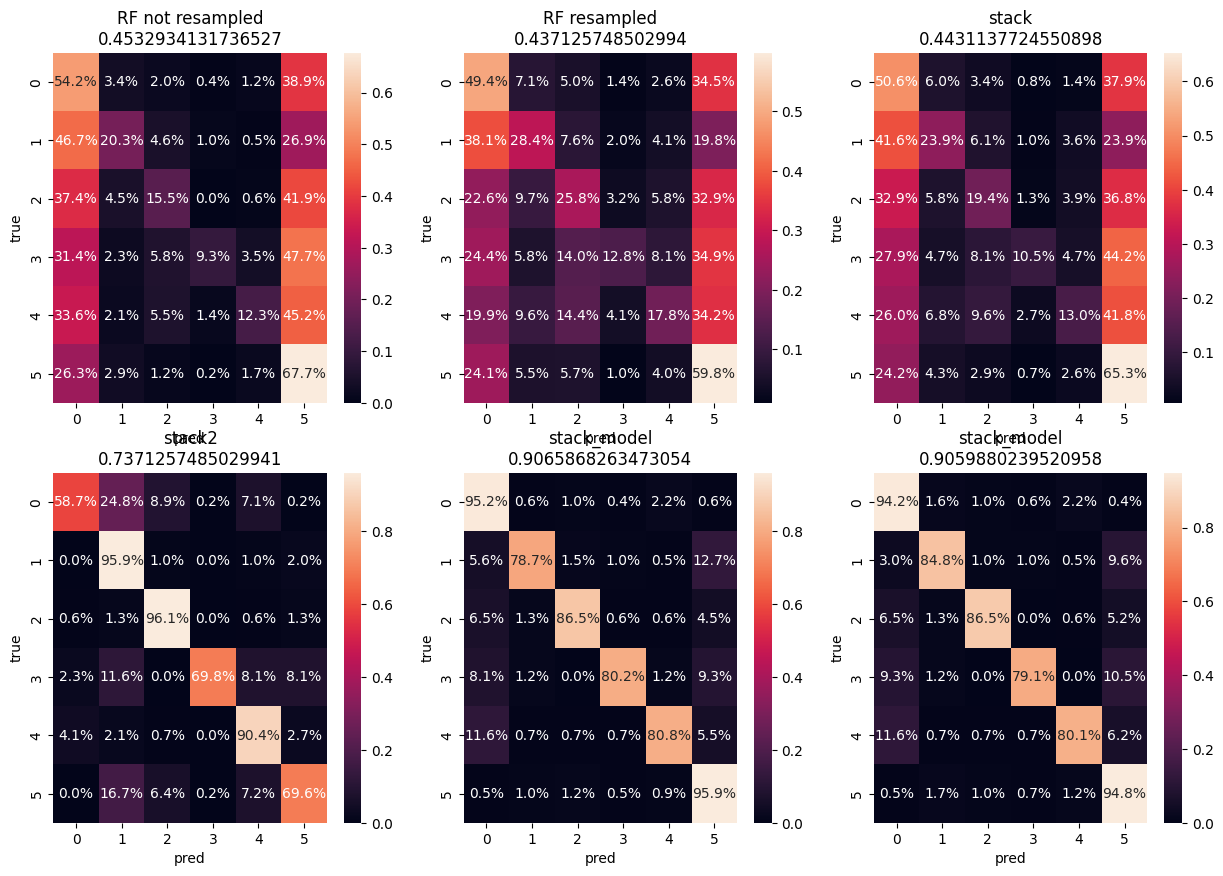

In [40]:
all_models = {
    'RF' : {'model' : RF, 'score': f1_score(y_valid, y_pred, average="micro")},
    'RF_sampled' : {'model' : best_model_res, 'score': f1_score(y_valid, y_pred_res, average="micro"), 'sm': sm},
    'stack RF/RF_res' : {'model' : [RF, best_model_res], 'score' : f1_score(y_valid, y_stack, average="micro")},
    'satck RFover/RFsub div' : {'model' : [best_models_sub['RandomForestClassifier'][0], best_models_over['RandomForestClassifier'][0]], 'score' : f1_score(y_valid, y_stack2, average="micro"), 'div': 1.7},
    'satck RFover/RFsub hand' : {'model' : stacked_model, 'estimators' :[best_models_sub['RandomForestClassifier'][0], best_models_over['RandomForestClassifier'][0]], 'score' : f1_score(y_valid, y_stack_model, average="micro")},
    'satck RFover/RFsub sklearn' : {'model' : best_stacked_model, 'score' : f1_score(y_valid, y_pred_stack, average="micro")}
}

for model_name, insights in all_models.items():
    print(f'{model_name} : {insights}')

f, ax = plt.subplots(2, 3, figsize=(15,10))
show_matrix(y_pred, y_valid, ax[0, 0], f'RF not resampled\n{f1_score(y_valid, y_pred, average="micro")}')
show_matrix(y_pred_res, y_valid, ax[0, 1], f'RF resampled\n{f1_score(y_valid, y_pred_res, average="micro")}')
show_matrix(y_stack, y_valid, ax[0, 2], f'stack\n{f1_score(y_valid, y_stack, average="micro")}')
show_matrix(y_stack2, y_valid, ax[1, 0], f'stack2\n{f1_score(y_valid, y_stack2, average="micro")}')
show_matrix(y_stack_model, y_valid, ax[1, 1], f'stack_model\n{f1_score(y_valid, y_stack_model, average="micro")}')
show_matrix(y_pred_stack, y_valid, ax[1, 2], f'stack_model\n{f1_score(y_valid, y_pred_stack, average="micro")}')